In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.impute import *

plt.style.use(style="seaborn")
%matplotlib inline

In [2]:
bucket = 'pothole'

data_key = '5589.csv'

data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (22,70,72,74,85,86,88,90,92,93,94,95,97,98,99,102,104,106,108,109,110,111,113,114,115,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,MeasurementId,TS_or_Distance,T,lat,lon,message,isComputed,FK_Trip,FK_MeasurementType,Created_Date,...,end_position_display.precision,end_position_display.longitude,end_position_display.county,end_position_display.state,end_position_display.street,end_position_display.postal_code,end_position_display.postcode,end_position_display.address,end_position_display.latitude,end_position_display.type
0,c491a854-311f-4ed8-a5a2-abf5add576cd,2020-11-01 11:54:51.563541+00:00,event.vehicle.motor,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,43f6e697-19b3-40f8-b95d-06c205fd3758,36c12ed9-3d71-4c87-985c-0156f3f3a3a8,2020-12-23 10:35:54.541221+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0c87b325-4e10-4c66-b588-a2d4ff4aad74,2020-11-01 11:54:51.563541+00:00,track.pos,55.73293,12.46941,"{""id"":""43f6e697-19b3-40f8-b95d-06c205fd3758"",""...",False,43f6e697-19b3-40f8-b95d-06c205fd3758,a69d9fe0-7896-49e2-9e8d-e36f0d54f286,2020-12-23 10:28:26.506338+00:00,...,street_segment,12.37962,Furesø Municipality,Capital Region of Denmark,Hillerødmotorvejen,3520.0,3520.0,"Hillerødmotorvejen, Farum, 3520, DK",55.802459,geocode
2,e9e66ef7-2e22-4d52-a9b5-4e4e9f27b3e1,2020-11-01 11:54:51.576198+00:00,obd.whl_trq_est,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,43f6e697-19b3-40f8-b95d-06c205fd3758,a1917940-8ad5-4296-b0ac-4cb9d070ce47,2020-12-23 11:40:43.998383+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,be871b9c-761c-4420-9bb1-d14b20681efd,2020-11-01 11:54:51.576239+00:00,obd.trq_eff,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,43f6e697-19b3-40f8-b95d-06c205fd3758,10d94f48-b85f-433b-b9e1-58f9b22ec441,2020-12-23 11:40:44.007629+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8fc83316-a912-425f-89d1-4f526ea91a76,2020-11-01 11:54:51.576239+00:00,obd.trq_req,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,43f6e697-19b3-40f8-b95d-06c205fd3758,e94864c5-29e6-4d2f-a470-f8b9799e9618,2020-12-23 11:40:44.016714+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(1929870, 121)

In [5]:
def drop_custom_columns(df):
  list_1 = ['FK_Trip','FK_MeasurementType','Created_Date','Updated_Date','start_time_utc','end_time_utc','Updated_Date']
  list_2 = ['obd.ww_f_req.value','obd.trac_cons.value','obd.trip_cons.value','obd.trip_cons_avg.value','obd.trip_dist.value',
 'obd.trip_spd_avg.value','obd.trq_eff.value','obd.trq_req.value', 'obd.whl_prs_fl.value','obd.whl_prs_fr.value','obd.whl_prs_rl.value',
 'obd.whl_prs_rr.value','obd.whl_trq_est.value','obd.whl_trq_pot_ri.value','obd.ww_f_req.value','obd.ww_f_stat.value',
 'obd.ww_f_stop.value']
  list_3 = ['duration','distanceKm','tag','rpi.temp.cpu.unit','rpi.temp.cpu.value','rpi.temp.gpu.unit',
 'rpi.temp.gpu.value','start_position_display.ntk_geocode_time','start_position_display.city','start_position_display.street_type',
 'start_position_display.country','start_position_display.street_name','start_position_display.provider','start_position_display.precision',
 'start_position_display.longitude','start_position_display.county','start_position_display.state','start_position_display.street',
 'start_position_display.postal_code','start_position_display.postcode','start_position_display.address','start_position_display.latitude',
 'start_position_display.type','end_position_display.ntk_geocode_time','end_position_display.city','end_position_display.street_type',
 'end_position_display.country','end_position_display.street_name','end_position_display.provider','end_position_display.precision',
 'end_position_display.longitude','end_position_display.county','end_position_display.state','end_position_display.street',
 'end_position_display.postal_code','end_position_display.postcode','end_position_display.address','end_position_display.latitude',
 'end_position_display.type']
  columns_should_be_deleted = list_1 + list_2 + list_3
  columns_which_are_really_in_df = []
  for column_name in columns_should_be_deleted:
    if column_name in df:
      columns_which_are_really_in_df.append(column_name)
  df = df.drop(columns_which_are_really_in_df, axis=1)
  return df

In [6]:
df = drop_custom_columns(df)

In [7]:
# checking of there is any values after "+" in column TS_or_Distance
culprit = [False, None]
for time_ in df["TS_or_Distance"]:
  two_parts = time_.split("+",)
  if two_parts[1] != "00:00":
    culprit = [True, time_]
if culprit[0]:
  print (culprit[1])

In [8]:
def split_a_utc_time(time_):
  preprocessed = time_.split("+",)[0]
  date_time = preprocessed.split(" ",)
  year_, month_, date_ = [int(number) for number in date_time[0].split("-", )]
  hour_, minute_, second_ = [int(number) for number in date_time[1][:date_time[1].index('.')].split(":", )]
  mseconds_ = int(date_time[1].split('.', )[1])
  result = {
      "year": year_,
      "month": month_,
      "date": date_,
      "hour": hour_,
      "minute": minute_,
      "second": second_,
      "mseconds": mseconds_
  }
  return result

In [9]:
# flattening the TS_or_Distance
target_column = "TS_or_Distance"
cells = ["year", "month", "date", "hour", "minute", "second", "mseconds"]
for time_cell_name in cells:
  df[target_column+"_"+time_cell_name] = 0

In [10]:
# splitting TS_or_Distance into multiple values and assigning for every rows
for index in range(10000):
  time_cells = split_a_utc_time(df[target_column][index])
  for time_cell_name in cells:
    df[target_column+"_"+time_cell_name][index] = time_cells[time_cell_name]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
pd.set_option('display.max_columns', None)
df.head()

,MeasurementId,TS_or_Distance,T,lat,lon,message,isComputed,id,@vid,@uid,@ts,@t,@rec,acc.xyz.z,acc.xyz.y,acc.xyz.x,@tag,obd.acc_long.value,obd.acc_trans.value,obd.acc_yaw.value,obd.asr_trq_req_dyn.value,obd.asr_trq_req_st.value,obd.brk_trq_elec.value,obd.brk_trq_req_dvr.value,obd.brk_trq_req_elec.value,obd.cons_avg.value,obd.f_dist.value,obd.msr_trq_req.value,obd.odo.value,obd.rpm.value,obd.rpm_elec.value,obd.rpm_fl.value,obd.rpm_fr.value,obd.rpm_rl.value,obd.rpm_rr.value,obd.sb_rem_fl.value,obd.sb_rem_fr.value,obd.sb_stat_rc.value,obd.sb_stat_rl.value,obd.sb_stat_rr.value,obd.spd.value,obd.spd_veh.value,obd.strg_acc.value,obd.strg_ang.value,obd.strg_pos.value,obd.temp.value,obd.temp_ext.value,obd.time.value,track.pos.utc,track.pos.alt,track.pos.nsat,track.pos.cog,track.pos.sog,track.pos.loc.lat,track.pos.loc.lon,start_position_lat,start_position_lng,end_position_lat,end_position_lng,device,TS_or_Distance_year,TS_or_Distance_month,TS_or_Distance_date,TS_or_Distance_hour,TS_or_Distance_minute,TS_or_Distance_second,TS_or_Distance_mseconds
0,c491a854-311f-4ed8-a5a2-abf5add576cd,2020-11-01 11:54:51.563541+00:00,event.vehicle.motor,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,00000000-0000-0000-0000-000000000000,23.0,4565c040-cbfb-dfb0-29c9-2a5041babfa6,2020-11-01T11:54:51.563541+00:00,event.vehicle.motor,2020-11-01T11:55:12.955799+00:00,NaN,NaN,NaN,vehicle/motor/running,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,11,1,11,54,51,563541
1,0c87b325-4e10-4c66-b588-a2d4ff4aad74,2020-11-01 11:54:51.563541+00:00,track.pos,55.73293,12.46941,"{""id"":""43f6e697-19b3-40f8-b95d-06c205fd3758"",""...",False,43f6e697-19b3-40f8-b95d-06c205fd3758,NaN,NaN,0001-01-01T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.73293,12.46941,55.80245,12.37965,85d44a66-4ecb-4fdc-91be-0a18b2d7ebdb,2020,11,1,11,54,51,563541
2,e9e66ef7-2e22-4d52-a9b5-4e4e9f27b3e1,2020-11-01 11:54:51.576198+00:00,obd.whl_trq_est,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,00000000-0000-0000-0000-000000000000,23.0,4565c040-cbfb-dfb0-29c9-2a5041babfa6,2020-11-01T11:54:51.576198+00:00,obd.whl_trq_est,2020-11-01T15:40:36.679279+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,11,1,11,54,51,576198
3,be871b9c-761c-4420-9bb1-d14b20681efd,2020-11-01 11:54:51.576239+00:00,obd.trq_eff,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,00000000-0000-0000-0000-000000000000,23.0,4565c040-cbfb-dfb0-29c9-2a5041babfa6,2020-11-01T11:54:51.576239+00:00,obd.trq_eff,2020-11-01T15:40:36.679301+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,11,1,11,54,51,576239
4,8fc83316-a912-425f-89d1-4f526ea91a76,2020-11-01 11:54:51.576239+00:00,obd.trq_req,NaN,NaN,"{""id"":""00000000-0000-0000-0000-000000000000"",""...",True,00000000-0000-0000-0000-000000000000,23.0,4565c040-cbfb-dfb0-29c9-2a5041babfa6,2020-11-01T11:54:51.576239+00:00,obd.trq_req,2020-11-01T15:40:36.679324+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,11,1,11,54,51,576239


In [12]:
df.shape

(1929870, 67)

In [13]:

null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

lat                           1929151
lon                           1929151
@vid                                2
@uid                                2
@t                                  2
@rec                                2
acc.xyz.z                     1881460
acc.xyz.y                     1881460
acc.xyz.x                     1881460
@tag                          1929863
obd.acc_long.value            1837885
obd.acc_trans.value           1837883
obd.acc_yaw.value             1837884
obd.asr_trq_req_dyn.value     1883878
obd.asr_trq_req_st.value      1883878
obd.brk_trq_elec.value        1837888
obd.brk_trq_req_dvr.value     1837882
obd.brk_trq_req_elec.value    1837886
obd.cons_avg.value            1928031
obd.f_dist.value              1920672
obd.msr_trq_req.value         1883878
obd.odo.value                 1920672
obd.rpm.value                 1837884
obd.rpm_elec.value            1837888
obd.rpm_fl.value              1883876
obd.rpm_fr.value              1883876
obd.rpm_rl.v

In [14]:
# get all columns
# used function Random to get total no.of columns and rows
import random
columns = []
for column_name in df.columns:
  # print (column_name, end="\t")
  columns.append(column_name)
print ("\nlength =", len(df.columns))
# number of rows in dataset
the_chosen_one = random.choice(columns)
number_of_rows = len(df[the_chosen_one])
print (number_of_rows)


length = 67
1929870


In [15]:
import json
index = 0
print (index)
message = json.loads(df["message"][index])
for label_name in message:
  if label_name in columns:
    print (df[label_name][index], "\t\t", message[label_name])

0
00000000-0000-0000-0000-000000000000 		 00000000-0000-0000-0000-000000000000
23.0 		 23
4565c040-cbfb-dfb0-29c9-2a5041babfa6 		 4565c040-cbfb-dfb0-29c9-2a5041babfa6
2020-11-01T11:54:51.563541+00:00 		 2020-11-01T11:54:51.563541+00:00
vehicle/motor/running 		 vehicle/motor/running
event.vehicle.motor 		 event.vehicle.motor
2020-11-01T11:55:12.955799+00:00 		 2020-11-01T11:55:12.955799+00:00


In [16]:
for column_name in columns:
  null_size = df[column_name].isna().sum()
  actual_values = number_of_rows - null_size
  # print (column_name, actual_values)

In [17]:
all_the_labels_in_all_the_messages = {}
for index in range(number_of_rows):
  if str(df["message"][index]) != "nan":
    message = json.loads(df["message"][index])
    for label_name in message:
      if "dict" in str(type(message[label_name])):
        for sub_label_name in message[label_name]:
          if sub_label_name not in all_the_labels_in_all_the_messages:
            all_the_labels_in_all_the_messages.update({
                sub_label_name: message[label_name][sub_label_name]
            })
      else:
        if label_name not in all_the_labels_in_all_the_messages:
          all_the_labels_in_all_the_messages.update({
              label_name: message[label_name]
          })

In [18]:
for label_name in all_the_labels_in_all_the_messages:
  if label_name not in df:
    print (label_name, all_the_labels_in_all_the_messages[label_name])
   

start_time_utc 0001-01-01T00:00:00+00:00
end_time_utc 0001-01-01T00:00:00+00:00
ntk_geocode_time 148
city Gladsaxe
street_type 
country Denmark
street_name Hillerødmotorvejen
provider OpenStreetMap
precision street_segment
longitude 12.469413050199
county Gladsaxe Municipality
state Capital Region of Denmark
street Hillerødmotorvejen
postal_code 2860
postcode 2860
address Hillerødmotorvejen, Gladsaxe, 2860, DK
latitude 55.7329362478212
type geocode
duration 2020-12-23T00:15:22.836232+00:00
distanceKm 16.7152902011491
tag personal
obd.whl_trq_est.value 19292.0
obd.trq_eff.value 1215.0
obd.trq_req.value 1215.0
obd.whl_prs_fl.value 2443.0499999999997
obd.whl_prs_rl.value 2388.15
obd.whl_prs_fr.value 2456.775
obd.whl_prs_rr.value 2388.15
obd.whl_trq_pot_ri.value 7692
obd.trac_cons.value 171
obd.ww_f_req.value 0
obd.trip_cons_avg.value 16.6
obd.trip_cons.value 13
obd.trip_dist.value 82.4
obd.trip_spd_avg.value 69.10000000000001
obd.ww_f_stat.value 0
obd.ww_f_stop.value 1
unit C
value 56.92


In [19]:
print (len(all_the_labels_in_all_the_messages))

92


In [20]:
# flattening dataset
f_data = df.copy()
newly_added_columns = []
# adding the new attributes to the dataset
for label_name in all_the_labels_in_all_the_messages:
  if label_name not in f_data:
    # print (label_name, all_the_labels_in_all_the_messages[label_name])
    f_data[label_name] = all_the_labels_in_all_the_messages[label_name]
    newly_added_columns.append(label_name)

In [21]:
# after adding the new column names
count = 0
for column_name in f_data.columns:
  count += 1
print (count)

106


In [22]:
f_data.drop({'message','id','@t','@uid','@rec',}, axis='columns', inplace=True)

In [23]:
f_data.isna()

,MeasurementId,TS_or_Distance,T,lat,lon,isComputed,@vid,@ts,acc.xyz.z,acc.xyz.y,acc.xyz.x,@tag,obd.acc_long.value,obd.acc_trans.value,obd.acc_yaw.value,obd.asr_trq_req_dyn.value,obd.asr_trq_req_st.value,obd.brk_trq_elec.value,obd.brk_trq_req_dvr.value,obd.brk_trq_req_elec.value,obd.cons_avg.value,obd.f_dist.value,obd.msr_trq_req.value,obd.odo.value,obd.rpm.value,obd.rpm_elec.value,obd.rpm_fl.value,obd.rpm_fr.value,obd.rpm_rl.value,obd.rpm_rr.value,obd.sb_rem_fl.value,obd.sb_rem_fr.value,obd.sb_stat_rc.value,obd.sb_stat_rl.value,obd.sb_stat_rr.value,obd.spd.value,obd.spd_veh.value,obd.strg_acc.value,obd.strg_ang.value,obd.strg_pos.value,obd.temp.value,obd.temp_ext.value,obd.time.value,track.pos.utc,track.pos.alt,track.pos.nsat,track.pos.cog,track.pos.sog,track.pos.loc.lat,track.pos.loc.lon,start_position_lat,start_position_lng,end_position_lat,end_position_lng,device,TS_or_Distance_year,TS_or_Distance_month,TS_or_Distance_date,TS_or_Distance_hour,TS_or_Distance_minute,TS_or_Distance_second,TS_or_Distance_mseconds,start_time_utc,end_time_utc,ntk_geocode_time,city,street_type,country,street_name,provider,precision,longitude,county,state,street,postal_code,postcode,address,latitude,type,duration,distanceKm,tag,obd.whl_trq_est.value,obd.trq_eff.value,obd.trq_req.value,obd.whl_prs_fl.value,obd.whl_prs_rl.value,obd.whl_prs_fr.value,obd.whl_prs_rr.value,obd.whl_trq_pot_ri.value,obd.trac_cons.value,obd.ww_f_req.value,obd.trip_cons_avg.value,obd.trip_cons.value,obd.trip_dist.value,obd.trip_spd_avg.value,obd.ww_f_stat.value,obd.ww_f_stop.value,unit,value
0,False,False,False,True,True,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True

In [24]:
import numpy as np
f_data = f_data.fillna(value=np.nan)

In [25]:
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent", verbose=0)

In [26]:
columns_having_numbers_and_nulls = []
for column_name in f_data.columns:
  dtype = f_data.dtypes[column_name]
  if dtype.name == "float64" and f_data[column_name].isnull().sum()<len(f_data[column_name]):
    columns_having_numbers_and_nulls.append(column_name)

In [27]:
f_data[columns_having_numbers_and_nulls]

,lat,lon,@vid,acc.xyz.z,acc.xyz.y,acc.xyz.x,obd.acc_long.value,obd.acc_trans.value,obd.acc_yaw.value,obd.asr_trq_req_dyn.value,obd.asr_trq_req_st.value,obd.brk_trq_elec.value,obd.brk_trq_req_dvr.value,obd.brk_trq_req_elec.value,obd.cons_avg.value,obd.f_dist.value,obd.msr_trq_req.value,obd.odo.value,obd.rpm.value,obd.rpm_elec.value,obd.rpm_fl.value,obd.rpm_fr.value,obd.rpm_rl.value,obd.rpm_rr.value,obd.sb_rem_fl.value,obd.sb_rem_fr.value,obd.sb_stat_rc.value,obd.sb_stat_rl.value,obd.sb_stat_rr.value,obd.spd.value,obd.spd_veh.value,obd.strg_acc.value,obd.strg_ang.value,obd.strg_pos.value,obd.temp.value,obd.temp_ext.value,obd.time.value,track.pos.alt,track.pos.nsat,track.pos.cog,track.pos.sog,track.pos.loc.lat,track.pos.loc.lon,start_position_lat,start_position_lng,end_position_lat,end_position_lng,longitude,latitude,distanceKm,obd.whl_trq_est.value,obd.trq_eff.value,obd.trq_req.value,obd.whl_prs_fl.value,obd.whl_prs_rl.value,obd.whl_prs_fr.value,obd.whl_prs_rr.value,obd.trip_cons_avg.value,obd.trip_dist.value,obd.trip_spd_avg.value,value
0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
1,55.73293,12.46941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.73293,12.46941,55.80245,12.37965,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
2,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
3,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
4,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929865,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,933.041674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
1929866,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,933.500007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
1929867,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,16.6,82.4,69.1,56.92
1929868,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.469413,55.732936,16.71529,19292.0,1215.0,1215.0,2443.05,2388.15,2456

In [28]:
imputer = imputer.fit(f_data[columns_having_numbers_and_nulls])
f_data[columns_having_numbers_and_nulls] = imputer.transform(f_data[columns_having_numbers_and_nulls])

In [29]:
f_data.head()

,MeasurementId,TS_or_Distance,T,lat,lon,isComputed,@vid,@ts,acc.xyz.z,acc.xyz.y,acc.xyz.x,@tag,obd.acc_long.value,obd.acc_trans.value,obd.acc_yaw.value,obd.asr_trq_req_dyn.value,obd.asr_trq_req_st.value,obd.brk_trq_elec.value,obd.brk_trq_req_dvr.value,obd.brk_trq_req_elec.value,obd.cons_avg.value,obd.f_dist.value,obd.msr_trq_req.value,obd.odo.value,obd.rpm.value,obd.rpm_elec.value,obd.rpm_fl.value,obd.rpm_fr.value,obd.rpm_rl.value,obd.rpm_rr.value,obd.sb_rem_fl.value,obd.sb_rem_fr.value,obd.sb_stat_rc.value,obd.sb_stat_rl.value,obd.sb_stat_rr.value,obd.spd.value,obd.spd_veh.value,obd.strg_acc.value,obd.strg_ang.value,obd.strg_pos.value,obd.temp.value,obd.temp_ext.value,obd.time.value,track.pos.utc,track.pos.alt,track.pos.nsat,track.pos.cog,track.pos.sog,track.pos.loc.lat,track.pos.loc.lon,start_position_lat,start_position_lng,end_position_lat,end_position_lng,device,TS_or_Distance_year,TS_or_Distance_month,TS_or_Distance_date,TS_or_Distance_hour,TS_or_Distance_minute,TS_or_Distance_second,TS_or_Distance_mseconds,start_time_utc,end_time_utc,ntk_geocode_time,city,street_type,country,street_name,provider,precision,longitude,county,state,street,postal_code,postcode,address,latitude,type,duration,distanceKm,tag,obd.whl_trq_est.value,obd.trq_eff.value,obd.trq_req.value,obd.whl_prs_fl.value,obd.whl_prs_rl.value,obd.whl_prs_fr.value,obd.whl_prs_rr.value,obd.whl_trq_pot_ri.value,obd.trac_cons.value,obd.ww_f_req.value,obd.trip_cons_avg.value,obd.trip_cons.value,obd.trip_dist.value,obd.trip_spd_avg.value,obd.ww_f_stat.value,obd.ww_f_stop.value,unit,value
0,c491a854-311f-4ed8-a5a2-abf5add576cd,2020-11-01 11:54:51.563541+00:00,event.vehicle.motor,55.71276,12.50457,True,23.0,2020-11-01T11:54:51.563541+00:00,1.0,-0.05,0.16,vehicle/motor/running,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,NaN,2020,11,1,11,54,51,563541,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"Hillerødmotorvejen, Gladsaxe, 2860, DK",55.732936,geocode,2020-12-23T00:15:22.836232+00:00,16.71529,personal,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,7692,171,0,16.6,13,82.4,69.1,0,1,C,56.92
1,0c87b325-4e10-4c66-b588-a2d4ff4aad74,2020-11-01 11:54:51.563541+00:00,track.pos,55.73293,12.46941,False,23.0,0001-01-01T00:00:00+00:00,1.0,-0.05,0.16,NaN,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,85d44a66-4ecb-4fdc-91be-0a18b2d7ebdb,2020,11,1,11,54,51,563541,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"Hillerødmotorvejen, Gladsaxe, 2860, DK",55.732936,geocode,2020-12-23T00:15:22.836232+00:00,16.71529,personal,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,7692,171,0,16.6,13,82.4,69.1,0,1,C,56.92
2,e9e66ef7-2e22-4d52-a9b5-4e4e9f27b3e1,2020-11-01 11:54:51.576198+00:00,obd.whl_trq_est,55.71276,12.50457,True,23.0,2020-11-01T11:54:51.576198+00:00,1.0,-0.05,0.16,NaN,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,NaN,2020,11,1,11,54,51,576198,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"

In [30]:
set(f_data["isComputed"])

{False, True}

In [31]:
f_data["isComputed"] = f_data["isComputed"].replace({True: 1, False: 0})
f_data.head()

,MeasurementId,TS_or_Distance,T,lat,lon,isComputed,@vid,@ts,acc.xyz.z,acc.xyz.y,acc.xyz.x,@tag,obd.acc_long.value,obd.acc_trans.value,obd.acc_yaw.value,obd.asr_trq_req_dyn.value,obd.asr_trq_req_st.value,obd.brk_trq_elec.value,obd.brk_trq_req_dvr.value,obd.brk_trq_req_elec.value,obd.cons_avg.value,obd.f_dist.value,obd.msr_trq_req.value,obd.odo.value,obd.rpm.value,obd.rpm_elec.value,obd.rpm_fl.value,obd.rpm_fr.value,obd.rpm_rl.value,obd.rpm_rr.value,obd.sb_rem_fl.value,obd.sb_rem_fr.value,obd.sb_stat_rc.value,obd.sb_stat_rl.value,obd.sb_stat_rr.value,obd.spd.value,obd.spd_veh.value,obd.strg_acc.value,obd.strg_ang.value,obd.strg_pos.value,obd.temp.value,obd.temp_ext.value,obd.time.value,track.pos.utc,track.pos.alt,track.pos.nsat,track.pos.cog,track.pos.sog,track.pos.loc.lat,track.pos.loc.lon,start_position_lat,start_position_lng,end_position_lat,end_position_lng,device,TS_or_Distance_year,TS_or_Distance_month,TS_or_Distance_date,TS_or_Distance_hour,TS_or_Distance_minute,TS_or_Distance_second,TS_or_Distance_mseconds,start_time_utc,end_time_utc,ntk_geocode_time,city,street_type,country,street_name,provider,precision,longitude,county,state,street,postal_code,postcode,address,latitude,type,duration,distanceKm,tag,obd.whl_trq_est.value,obd.trq_eff.value,obd.trq_req.value,obd.whl_prs_fl.value,obd.whl_prs_rl.value,obd.whl_prs_fr.value,obd.whl_prs_rr.value,obd.whl_trq_pot_ri.value,obd.trac_cons.value,obd.ww_f_req.value,obd.trip_cons_avg.value,obd.trip_cons.value,obd.trip_dist.value,obd.trip_spd_avg.value,obd.ww_f_stat.value,obd.ww_f_stop.value,unit,value
0,c491a854-311f-4ed8-a5a2-abf5add576cd,2020-11-01 11:54:51.563541+00:00,event.vehicle.motor,55.71276,12.50457,1,23.0,2020-11-01T11:54:51.563541+00:00,1.0,-0.05,0.16,vehicle/motor/running,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,NaN,2020,11,1,11,54,51,563541,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"Hillerødmotorvejen, Gladsaxe, 2860, DK",55.732936,geocode,2020-12-23T00:15:22.836232+00:00,16.71529,personal,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,7692,171,0,16.6,13,82.4,69.1,0,1,C,56.92
1,0c87b325-4e10-4c66-b588-a2d4ff4aad74,2020-11-01 11:54:51.563541+00:00,track.pos,55.73293,12.46941,0,23.0,0001-01-01T00:00:00+00:00,1.0,-0.05,0.16,NaN,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,85d44a66-4ecb-4fdc-91be-0a18b2d7ebdb,2020,11,1,11,54,51,563541,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"Hillerødmotorvejen, Gladsaxe, 2860, DK",55.732936,geocode,2020-12-23T00:15:22.836232+00:00,16.71529,personal,19292.0,1215.0,1215.0,2443.05,2388.15,2456.775,2388.15,7692,171,0,16.6,13,82.4,69.1,0,1,C,56.92
2,e9e66ef7-2e22-4d52-a9b5-4e4e9f27b3e1,2020-11-01 11:54:51.576198+00:00,obd.whl_trq_est,55.71276,12.50457,1,23.0,2020-11-01T11:54:51.576198+00:00,1.0,-0.05,0.16,NaN,397.0,65536.0,2251.6,2847.0,2847.0,2.0,-8188.0,8188.0,16.5,0.6,800.0,18447.59,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,65535.0,65535.0,65532.0,22.0,93.0,776.0,NaN,6.6,5.0,115.45,96.0,55.71276,12.50457,55.73293,12.46941,55.80245,12.37965,NaN,2020,11,1,11,54,51,576198,0001-01-01T00:00:00+00:00,0001-01-01T00:00:00+00:00,148,Gladsaxe,,Denmark,Hillerødmotorvejen,OpenStreetMap,street_segment,12.469413,Gladsaxe Municipality,Capital Region of Denmark,Hillerødmotorvejen,2860,2860,"Hillerødmo

In [32]:
f_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929870 entries, 0 to 1929869
Columns: 101 entries, MeasurementId to value
dtypes: float64(61), int64(15), object(25)
memory usage: 1.5+ GB


In [33]:
# Columns to detect pothole 
f_data1 = f_data[["TS_or_Distance_second","acc.xyz.z","acc.xyz.y","acc.xyz.x","lat","lon","obd.spd_veh.value",
                 "obd.strg_acc.value","obd.acc_long.value","obd.brk_trq_req_elec.value","obd.acc_trans.value","obd.acc_yaw.value"]]
f_data1.head()

,TS_or_Distance_second,acc.xyz.z,acc.xyz.y,acc.xyz.x,lat,lon,obd.spd_veh.value,obd.strg_acc.value,obd.acc_long.value,obd.brk_trq_req_elec.value,obd.acc_trans.value,obd.acc_yaw.value
0,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
1,51,1.0,-0.05,0.16,55.73293,12.46941,0.0,65535.0,397.0,8188.0,65536.0,2251.6
2,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
3,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
4,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6


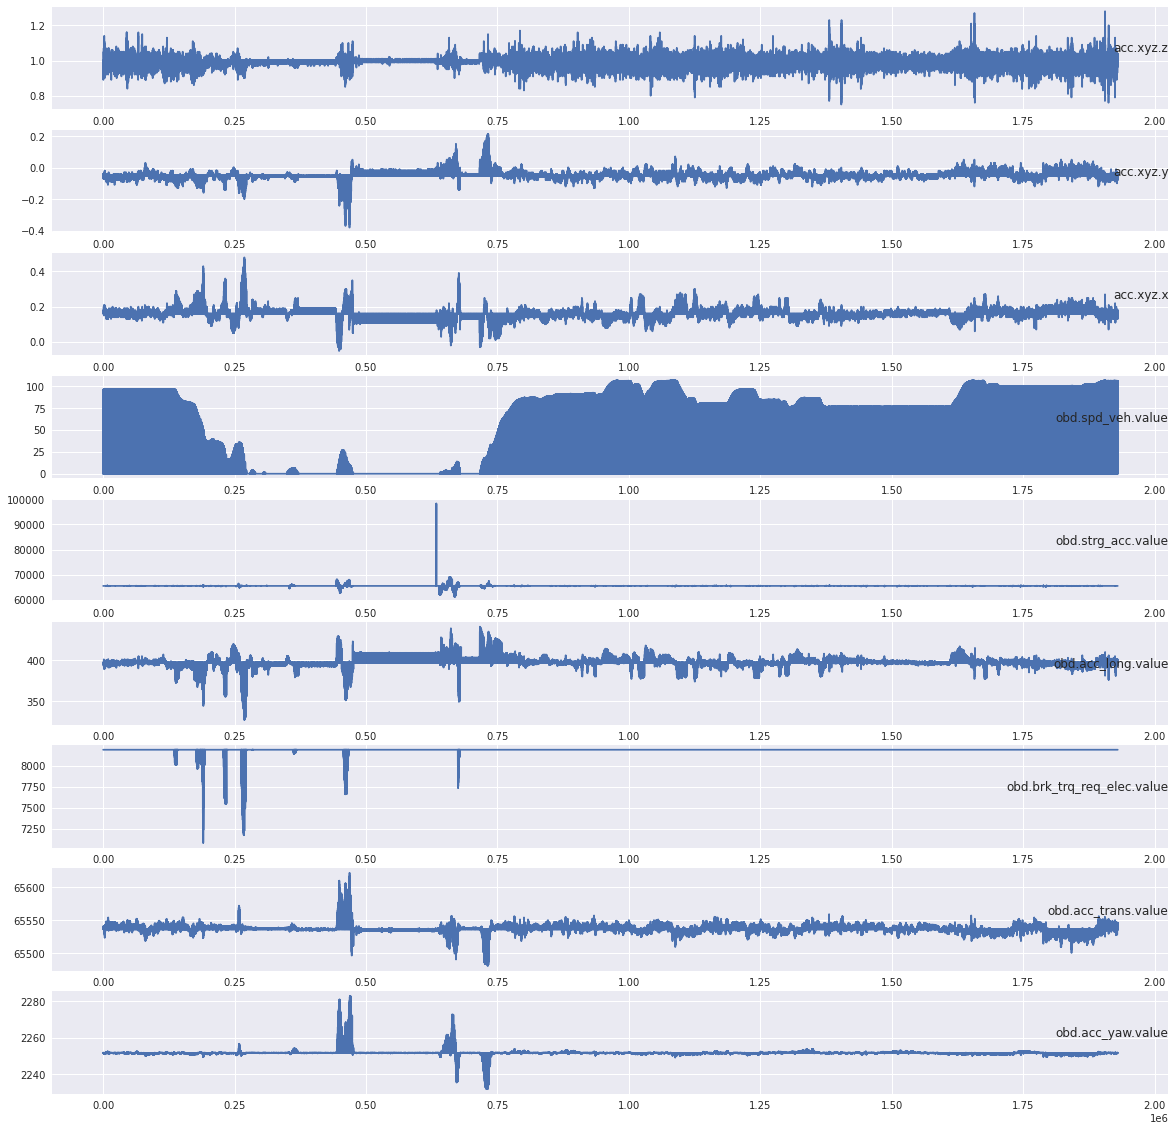

In [34]:
from matplotlib import pyplot
values = f_data1.values
#specify columns to plot
groups = [1,2,3,6,7,8,9,10,11]
i = 1
#plot each column
pyplot.figure(figsize=(20,20))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(f_data1.columns[group], y=0.5, loc='right')
    i+= 1
pyplot.show()

array([<AxesSubplot:xlabel='TS_or_Distance'>,
       <AxesSubplot:xlabel='TS_or_Distance'>,
       <AxesSubplot:xlabel='TS_or_Distance'>], dtype=object)

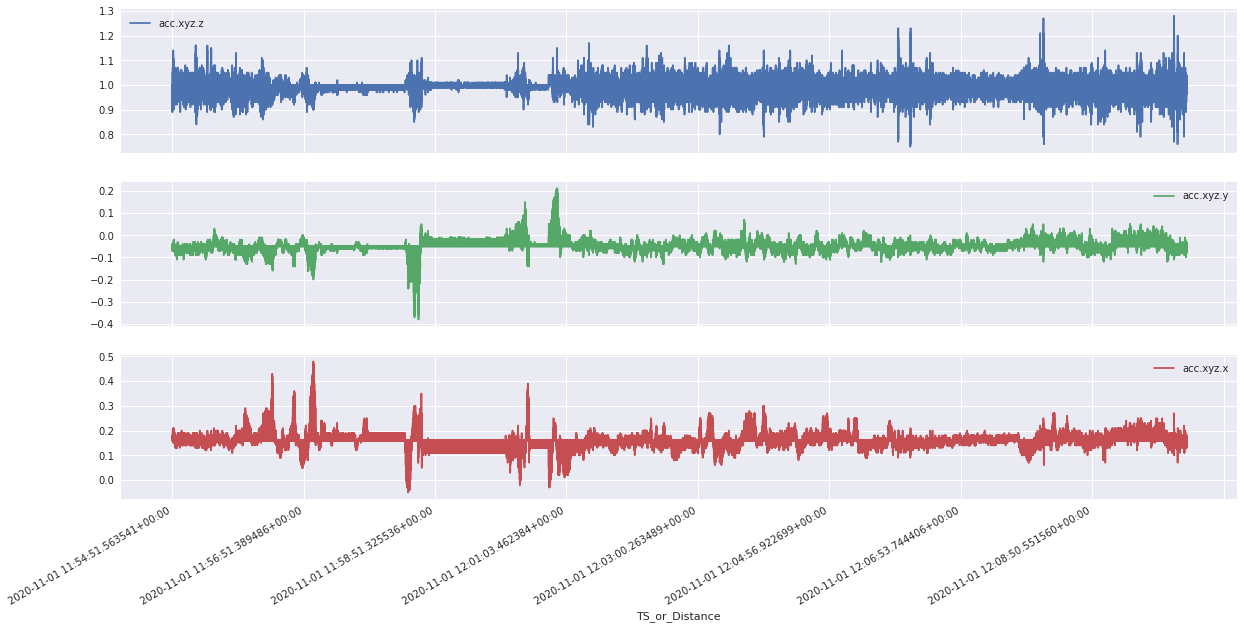

In [35]:
f_data.set_index('TS_or_Distance')[['acc.xyz.z','acc.xyz.y','acc.xyz.x']].plot(subplots=True, figsize =(20,10))

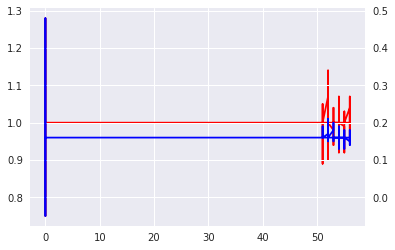

In [36]:
x = f_data1['TS_or_Distance_second'] 
y1 = f_data1['acc.xyz.z']
y2 = f_data1['acc.xyz.x']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'acc.xyz.z', color ='r')
curve2 = ax2.plot(x, y2, label = 'acc.xyz.x', color ='b')
plt.plot()
plt.show()

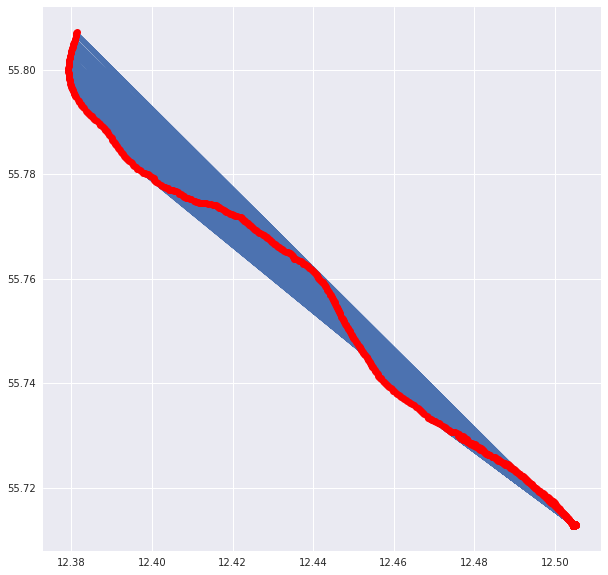

In [37]:
fig = plt.subplots(figsize =(10,10))
plt.plot(f_data1['lon'].values, f_data1['lat'].values)
plt.plot(f_data1['lon'].values, f_data1['lat'].values, 'ro');

In [38]:
!pip install folium

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [39]:
import folium 
copenhagen = [55.6761, 12.5683]
Map = folium.Map(copenhagen, zoom_start=4,titles='stamen Toner' )
Map

In [40]:

for col in f_data1.columns:
    if f_data1[col].dtype == "object":
        le = LabelEncoder()
        f_data1[col].fillna("None", inplace=True)
        le.fit(list(f_data1[col].astype(str).values))
        f_data1[col] = le.transform(list(f_data[col].astype(str).values))
    else:
        f_data1[col].fillna(-999, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [41]:
f_data1.head()

,TS_or_Distance_second,acc.xyz.z,acc.xyz.y,acc.xyz.x,lat,lon,obd.spd_veh.value,obd.strg_acc.value,obd.acc_long.value,obd.brk_trq_req_elec.value,obd.acc_trans.value,obd.acc_yaw.value
0,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
1,51,1.0,-0.05,0.16,55.73293,12.46941,0.0,65535.0,397.0,8188.0,65536.0,2251.6
2,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
3,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6
4,51,1.0,-0.05,0.16,55.71276,12.50457,0.0,65535.0,397.0,8188.0,65536.0,2251.6


In [42]:
contamination = 0.01
f_data1 = f_data1.copy()

Isolation Forest - Training the model

In [43]:
%%time

model = IsolationForest(contamination=contamination, n_estimators=100)
model.fit(f_data1)

CPU times: user 56.3 s, sys: 13.3 s, total: 1min 9s
Wall time: 1min 9s


IsolationForest(contamination=0.01)

In [44]:
f_data1["iforest"] = pd.Series(model.predict(f_data1))
f_data1["iforest"] = f_data1["iforest"].map({1: 0, -1: 1})
print(f_data1["iforest"].value_counts())

0    1910572
1      19298
Name: iforest, dtype: int64


In [45]:
18874/1910996

0.009876525120931703

KMeans Cluster

Elbow Method to Identify Clusters

In [46]:
import sklearn.cluster as cluster

In [47]:
df_short =f_data1[['acc.xyz.z','acc.xyz.x']]

In [48]:
# WSS = within-cluster-sum of squared
K=range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k, init="k-means++")
    kmeans=kmeans.fit(df_short)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [49]:
mycenters=pd.DataFrame({'Clusters':K, 'WSS':wss})
mycenters

,Clusters,WSS
0,1,152.559252
1,2,109.028458
2,3,82.500585
3,4,60.876362
4,5,49.342546
5,6,41.557640
6,7,35.018401
7,8,30.010727
8,9,26.755475
9,10,24.392113


<AxesSubplot:xlabel='Clusters', ylabel='WSS'>

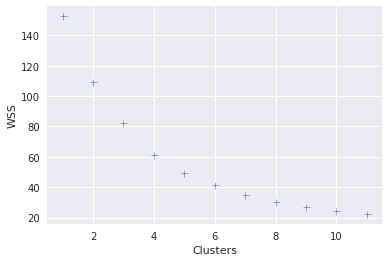

In [50]:
import seaborn as sns
sns.scatterplot(x ='Clusters', y = 'WSS', data =mycenters, marker="+")

In [51]:
# 3 clusters are identified as per Elbow Method

In [52]:
import sklearn.metrics as metrics

In [53]:
for i in range(2,12):
    labels=cluster.KMeans(n_clusters=i, init="k-means++", random_state=200).fit(df_short).labels_
    print("Silhouette score for k(clusters) = "+str(i)+" is "
    +str(metrics.silhouette_score(df_short,labels,metric="euclidean",sample_size=1000, random_state=100)))

Silhouette score for k(clusters) = 2 is 0.9750111348059874
Silhouette score for k(clusters) = 3 is 0.9750221382148245
Silhouette score for k(clusters) = 4 is 0.9779689358946271
Silhouette score for k(clusters) = 5 is 0.980176195231664
Silhouette score for k(clusters) = 6 is 0.9795187242291716
Silhouette score for k(clusters) = 7 is 0.9795187242291716
Silhouette score for k(clusters) = 8 is 0.9788905445965017
Silhouette score for k(clusters) = 9 is 0.9780747708573112
Silhouette score for k(clusters) = 10 is 0.9759362428808483
Silhouette score for k(clusters) = 11 is 0.9743916842620259


Perform K-Mean Clustering with 3 clusters

In [54]:
kmeans = cluster.KMeans(n_clusters=3, init="k-means++")
kmeans = kmeans.fit(f_data1[['acc.xyz.z','acc.xyz.x']])

In [55]:
# Plot Clusters on Chart
f_data1['Clusters'] = kmeans.labels_

<AxesSubplot:xlabel='acc.xyz.z', ylabel='acc.xyz.x'>

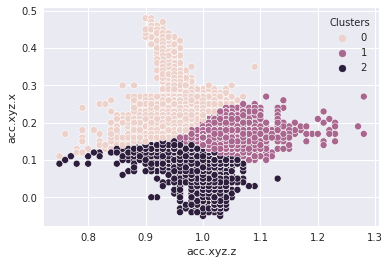

In [56]:
sns.scatterplot(x='acc.xyz.z', y='acc.xyz.x', hue='Clusters', data=f_data1)

Hierarchical Clustering



In [57]:

from sklearn.preprocessing import normalize
data_scaled = normalize(f_data1)
data_scaled = pd.DataFrame(data_scaled, columns=f_data1.columns)
data_scaled.head()

,TS_or_Distance_second,acc.xyz.z,acc.xyz.y,acc.xyz.x,lat,lon,obd.spd_veh.value,obd.strg_acc.value,obd.acc_long.value,obd.brk_trq_req_elec.value,obd.acc_trans.value,obd.acc_yaw.value,iforest,Clusters
0,0.000548,0.000011,-5.372283e-07,0.000002,0.000599,0.000134,0.0,0.704145,0.004266,0.087977,0.704156,0.024192,0.0,0.000011
1,0.000548,0.000011,-5.372283e-07,0.000002,0.000599,0.000134,0.0,0.704145,0.004266,0.087977,0.704156,0.024192,0.0,0.000011
2,0.000548,0.000011,-5.372283e-07,0.000002,0.000599,0.000134,0.0,0.704145,0.004266,0.087977,0.704156,0.024192,0.0,0.000011
3,0.000548,0.000011,-5.372283e-07,0.000002,0.000599,0.000134,0.0,0.704145,0.004266,0.087977,0.704156,0.024192,0.0,0.000011
4,0.000548,0.000011,-5.372283e-07,0.000002,0.000599,0.000134,0.0,0.704145,0.004266,0.087977,0.704156,0.024192,0.0,0.000011


In [61]:
from sklearn.datasets import make_blobs

In [95]:
data_scaled = make_blobs(n_samples = 100,
                    n_features = 2,
                    centers= 4,
                    cluster_std = 1.6,
                    random_state = 50)

In [96]:
points = data_scaled[0]

In [97]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

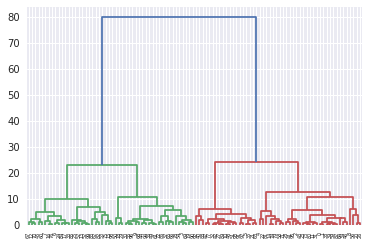

In [98]:
#create a dendrogram
dendrogram = sch.dendrogram(sch.linkage(points, method = 'ward'))

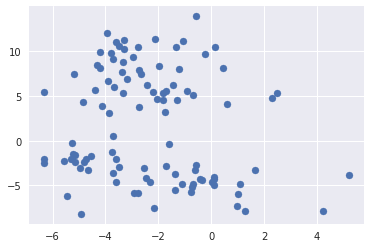

In [99]:
#scatter plot
plt.scatter(data_scaled[0][:,0], data_scaled[0][:,1])

In [100]:
# perform the actual clustering
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [101]:
# Assisgn each datapoint to cluster
y_hc = hc.fit_predict(points)

In [102]:
hc.labels_

array([0, 0, 0, 1, 0, 2, 3, 3, 0, 1, 2, 0, 3, 3, 0, 3, 3, 3, 1, 1, 0, 2,
       0, 0, 3, 3, 0, 2, 0, 1, 1, 0, 2, 3, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0,
       1, 3, 0, 2, 2, 1, 1, 2, 3, 3, 1, 1, 0, 3, 0, 0, 3, 1, 3, 2, 0, 1,
       1, 3, 1, 1, 3, 0, 1, 0, 0, 3, 3, 2, 1, 0, 0, 0, 3, 3, 3, 3, 1, 0,
       2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 3, 3])

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

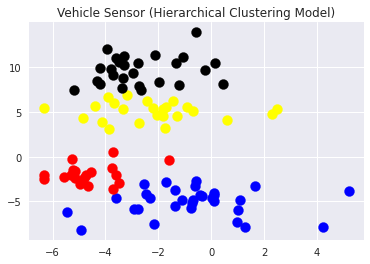

In [107]:
#Visualize 

plt.scatter(points[y_hc ==0,0], points[y_hc ==0,1], s=100, c='blue')
plt.scatter(points[y_hc ==1,0], points[y_hc ==1,1], s=100, c='yellow')
plt.scatter(points[y_hc ==2,0], points[y_hc ==2,1], s=100, c='red')
plt.scatter(points[y_hc ==3,0], points[y_hc ==3,1], s=100, c='black')
plt.title('Vehicle Sensor (Hierarchical Clustering Model)')

#plot centroids
plt.scatter()

In [113]:
train = f_data1.iloc[:1543896]
test = f_data1.iloc[1543896:]
print("Trainign dataset shape:", train.shape)
print("Testing dataset shape:",test.shape)

Trainign dataset shape: (1543896, 14)
Testing dataset shape: (385974, 14)


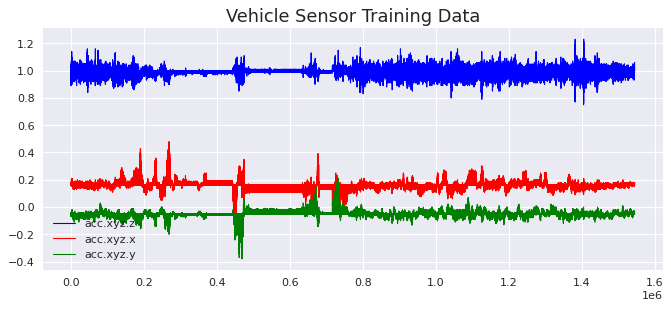

In [126]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(train['acc.xyz.z'], label='acc.xyz.z', color='blue', animated = True, linewidth=1)
ax.plot(train['acc.xyz.x'], label='acc.xyz.x', color='red', animated = True, linewidth=1)
ax.plot(train['acc.xyz.y'], label='acc.xyz.y', color='green', animated = True, linewidth=1)
 
plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

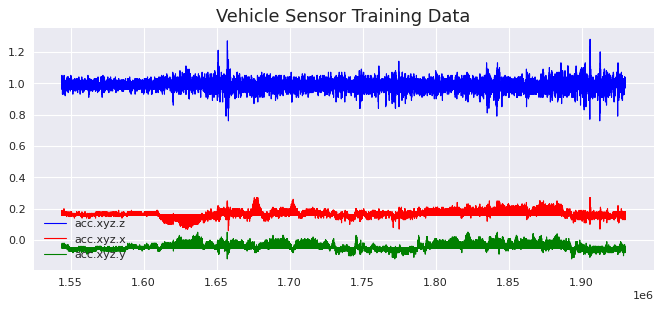

In [131]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(test['acc.xyz.z'], label='acc.xyz.z', color='blue', animated = True, linewidth=1)
ax.plot(test['acc.xyz.x'], label='acc.xyz.x', color='red', animated = True, linewidth=1)
ax.plot(test['acc.xyz.y'], label='acc.xyz.y', color='green', animated = True, linewidth=1)
 
plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

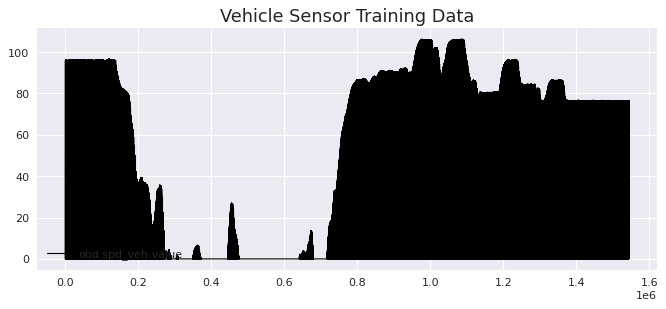

In [127]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)

ax.plot(train['obd.spd_veh.value'], label='obd.spd_veh.value', color='black', animated = True, linewidth=1) 

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

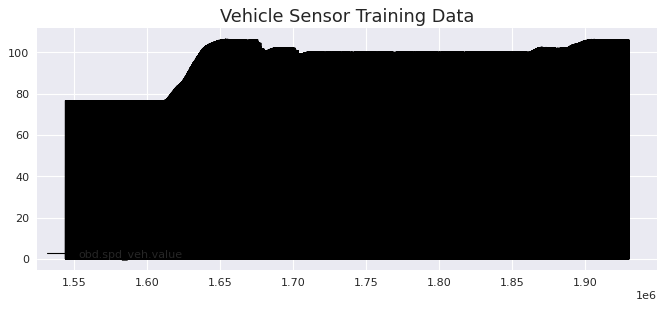

In [132]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)

ax.plot(test['obd.spd_veh.value'], label='obd.spd_veh.value', color='black', animated = True, linewidth=1) 

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

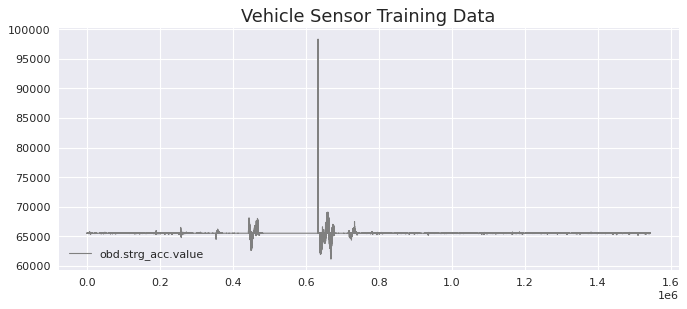

In [128]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(train['obd.strg_acc.value'], label='obd.strg_acc.value', color='grey', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

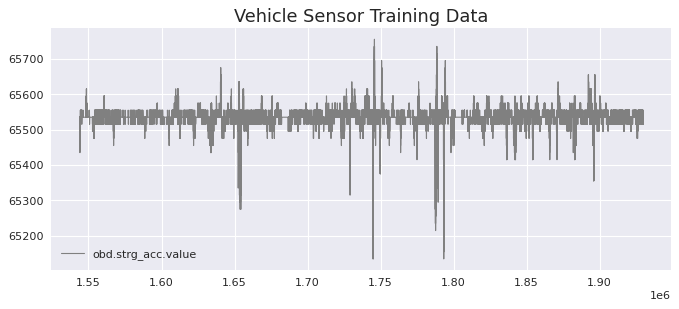

In [133]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(test['obd.strg_acc.value'], label='obd.strg_acc.value', color='grey', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

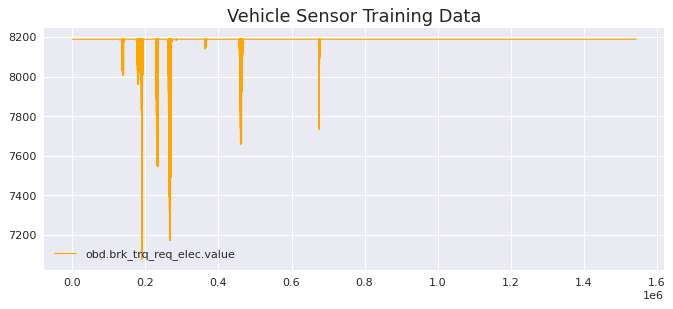

In [135]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(train['obd.brk_trq_req_elec.value'], label='obd.brk_trq_req_elec.value', color='orange', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

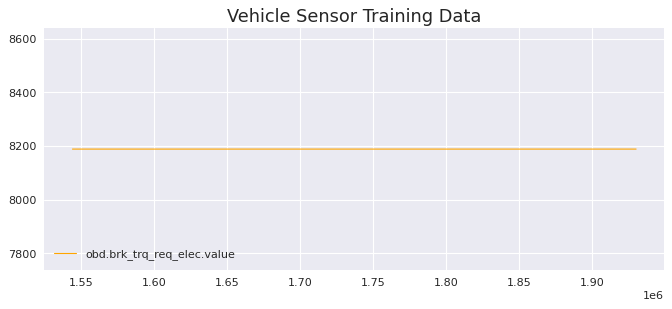

In [136]:
fig, ax = plt.subplots(figsize=(10,4), dpi=80)
ax.plot(test['obd.brk_trq_req_elec.value'], label='obd.brk_trq_req_elec.value', color='orange', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Vehicle Sensor Training Data', fontsize=16)

plt.show()

In [143]:
#normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
scaler_filename= 'Vehicle Sensor'


In [144]:
#reshape inpute for LSTM 
x_train = x_train.reshape(x_train.shape[0],1, x_train.shape[1])
print("Training Data Shape:", x_train.shape)
x_test = x_test.reshape(x_test.shape[0],1, x_test.shape[1])
print("Test Data Shape:", x_test.shape)



Training Data Shape: (1543896, 1, 14)
Test Data Shape: (385974, 1, 14)
